# Ch5. 特征选择:对坏属性说不

本章会讨论特征工程的一个子集，称为特征选择。特征选择是从原始数据中选择对于预测流水线而言最好的特征的过程。更正式地说，给定n个特征，我们搜索其中包括k(k<n)个特征的子集来改善机器学习流水线的性能。一般来说，我们的意思是:

特征选择尝试剔除数据中的噪声。这个定义包括两个需要解决的问题:

- 找到k特征子集的办法;
- 在机器学习中对“更好”的定义。

本章的大部分内容着重讲解寻找这类子集的方法，及其工作原理的基础。本章将特征选择的方法分为两大类:基于统计的特征选择，以及基于模型的特征选择。这种分类也许不能100%捕捉到特征选择在科学性和艺术性上的复杂程度，但是可以推动机器学习流水线输出真实、可应用的结果。

在深入探讨这些方法之前，首先讨论一下如何更好地理解并定义“更好”这个概念。这个概念会贯穿本章乃至本书的剩余部分。

本章会涉及如下主题:

- 在特征工程中实现更好的性能;
- 创建基准机器学习流水线;
- 特征选择的类型;
- 选用正确的特征选择方法。

## 5.1 在特征工程中实现更好的性能

在本书中，当我们讨论特征工程的方法时，需要对“更好”下定义。实际上，我们的目标是实现更好的预测性能，而且仅使用简单的指标进行测量，例如分类任务的准确率和回归任务的均方根误差(大部分是准确率)。我们还可以测量和跟踪其他指标，以评估预测的性能。

例如，分类任务可以使用如下指标:

- 真阳性率和假阳性率;
- 灵敏度(真阳性率)和特异性;
- 假阴性率和假阳性率。

回归任务则可以使用:

- 平均绝对误差;
- $R^2$;

这个列表还可以继续延长。虽然我们不会放弃用以上指标量化性能的想法，但是也可以测量其他元指标。元指标是指不直接与模型预测性能相关的指标，它们试图衡量周遭的性能，包括:

- 模型拟合/训练所需的时间;
- 拟合后的模型预测新实例的时间;
- 需要持久化(永久保存)的数据大小。

这补充了更好的定义，因为这些指标在预测性能之外涵盖了机器学习流水线的更多方面。为了跟踪这些指标，我们可以创建一个函数，通用到足以评估若干模型，同时精细到可以提供每个模型的指标。我们会利用 `get_best_model_and_accuracy` 函数，完成以下任务:

- 搜索所有给定的参数，优化机器学习流水线;
- 输出有助于评估流水线质量的指标。

我们按如下办法定义该函数:

In [1]:
from sklearn.model_selection import GridSearchCV

def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0.)# 如果报错，结果是0
    grid.fit(X, y)
    # 经典的性能指标
    print("Best Accuracy: {}".format(grid.best_score_))
    # 得到最佳准确率的最佳参数
    print("Best Parameters: {}".format(grid.best_params_)) # 拟合的平均时间(秒)
    print("Average Time to Fit (s):{}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))) # 预测的平均时间(秒)
    # 从该指标可以看出模型在真实世界的性能
    print("Average Time to Score (s):{}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

### 案例分析:信用卡逾期数据集

In [2]:
import numpy as np
import pandas as pd

np.random.seed(123)
credit_card_default= pd.read_csv('/Users/renyanmeng/Feature-Engineering-Made-Easy-master/data/credit_card_default.csv')
credit_card_default.shape

(30000, 24)

In [3]:
credit_card_default.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.323,129747.662,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.604,0.489,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853,0.790,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.552,0.522,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.486,9.218,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.017,1.124,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.134,1.197,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166,1.197,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.221,1.169,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266,1.133,-2.0,-1.00,0.0,0.00,8.0


In [4]:
credit_card_default.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [5]:
X = credit_card_default.drop("default payment next month", axis=1)
y = credit_card_default["default payment next month"]

In [6]:
# 取空准确率
y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

## 5.2 创建基准机器学习流水线

在前几章里，我们都提供了一个全章通用的机器学习模型。在本章中，我们会做一些工作，寻找最符合我们需求的机器学习模型，然后通过特征选择来增强模型。先导入4种模型:

- 逻辑回归;
- K最近邻(KNN);
- 决策树;
- 随机森林。

In [7]:
# 导入4种模型
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
# 为网格搜索设置变量
# 先设置机器学习模型的参数
# 逻辑回归
lr_params = {'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']}
# KNN
knn_params = {'n_neighbors': [1, 3, 5, 7]}
# 决策树
tree_params = {'max_depth':[None, 1, 3, 5, 7]}
# 随机森林
forest_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 1, 3, 5, 7]}

In [9]:
# 实例化机器学习模型
lr = LogisticRegression()
knn = KNeighborsClassifier()
d_tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

我们在所有的模型上运行评估函数，了解一下效果的好坏。

In [10]:
import warnings

warnings.filterwarnings('ignore')

get_best_model_and_accuracy(lr, lr_params, X, y)

Best Accuracy: 0.8095666666666667
Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Average Time to Fit (s):0.397
Average Time to Score (s):0.002


In [11]:
import warnings

warnings.filterwarnings('ignore')
models = [lr, knn, d_tree, forest]
params = [lr_params, knn_params, tree_params, forest_params]
for model, p in zip(models, params):
    print(f"{model}")
    get_best_model_and_accuracy(model, p, X, y)
    print("--"*20)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Best Accuracy: 0.8096
Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Average Time to Fit (s):0.49
Average Time to Score (s):0.002
----------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Best Accuracy: 0.7602333333333333
Best Parameters: {'n_neighbors': 7}
Average Time to Fit (s):0.017
Average Time to Score (s):0.752
----------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
       

不出所料，KNN在拟合时间上表现得更好。因为在拟合时，KNN只需要按方便检索和及时处理的方法存储数据。注意，这里的准确率甚至不如空准确率!你有可能在考虑原因是什么。如果你想到“等等，KNN是按照欧几里得距离进行预测的，在非标准数据上可能会失效，但是其他3个算法不会受此影响”，那么你是对的。

KNN是基于距离的模型，使用空间的紧密度衡量，假定所有的特征尺度相同，但是我们知道数据并不是这样。因此对于KNN，我们需要更复杂的流水线，以更准确地评估基准性能。代码如下:

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# 为流水线设置 KNN 参数
knn_pipe_params = {"classifier__{}".format(k): v for k, v in knn_params.items()}
knn_pipe_params

{'classifier__n_neighbors': [1, 3, 5, 7]}

In [13]:
# KNN 需要标准化的参数
knn_pipe = Pipeline([("scale", StandardScaler()), ("classifier", knn)])

In [14]:
# 拟合快，预测慢
get_best_model_and_accuracy(knn_pipe, knn_pipe_params, X, y)

Best Accuracy: 0.8008
Best Parameters: {'classifier__n_neighbors': 7}
Average Time to Fit (s):0.03
Average Time to Score (s):6.095


## 5.3 特征选择的类型

回想一下，选择特征是为了提高预测能力，降低时间成本。所以这里介绍两种类型:基于统计和基于模型的特征选择。基于统计的特征选择很大程度上依赖于机器学习模型之外的统计测试，以便在流水线的训练阶段选择特征。基于模型的特征选择则依赖于一个预处理步骤，需要训练一个辅助的机器学习模型，并利用其预测能力来选择特征。

### 5.3.1 基于统计的特征选择

本章会使用两个新概念帮我们选择特征:

- 皮尔逊相关系数(Pearsoncorrelations);
- 假设检验。

#### 1. 使用皮尔逊相关系数

In [15]:
credit_card_default.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
LIMIT_BAL,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
PAY_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


In [16]:
import seaborn as sns
import matplotlib.style as style
style.use("fivethirtyeight")

sns.heatmap(credit_card_default.corr())

In [17]:
credit_card_default.corr()["default payment next month"]

LIMIT_BAL                    -0.153520
SEX                          -0.039961
EDUCATION                     0.028006
MARRIAGE                     -0.024339
AGE                           0.013890
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
BILL_AMT1                    -0.019644
BILL_AMT2                    -0.014193
BILL_AMT3                    -0.014076
BILL_AMT4                    -0.010156
BILL_AMT5                    -0.006760
BILL_AMT6                    -0.005372
PAY_AMT1                     -0.072929
PAY_AMT2                     -0.058579
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT5                     -0.055124
PAY_AMT6                     -0.053183
default payment next month    1.000000
Name: default payment next month, dtype: float64

In [18]:
credit_card_default.corr()["default payment next month"].abs() > .2

LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                          True
PAY_2                          True
PAY_3                          True
PAY_4                          True
PAY_5                          True
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default payment next month     True
Name: default payment next month, dtype: bool

In [19]:
# 存储特征
highly_correlated_features = \
credit_card_default.columns[credit_card_default.corr()["default payment next month"].abs() > .2]

highly_correlated_features

Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'default payment next month'],
      dtype='object')

In [20]:
# 删掉响应变量
highly_correlated_features = highly_correlated_features.drop("default payment next month")
highly_correlated_features

Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'], dtype='object')

In [21]:
# 只有5个高度关联的变量
X_subsetted = credit_card_default[highly_correlated_features]

get_best_model_and_accuracy(d_tree, tree_params, X_subsetted, y)
# 略差一点，但是拟合快了约20倍

Best Accuracy: 0.8196666666666667
Best Parameters: {'max_depth': 3}
Average Time to Fit (s):0.007
Average Time to Score (s):0.002


In [22]:
# 相関係数高い変数選択変換器
from sklearn.base import TransformerMixin, BaseEstimator

class CustomCorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        # 保存响应变量
        self.response = response
        # 保存阈值
        self.threshold = threshold
        # 初始化一个变量，存放要保留的特征名
        self.cols_to_keep = cols_to_keep
    def transform(self, X):
        # 转换会选择合适的列
        return X[self.cols_to_keep]
    
    def fit(self, X, *_):
        # 创建新的DataFrame，存放特征和响应
        df = pd.concat([X, self.response], axis=1)
        # 保存高于阈值的列的名称
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        # 只保留 X 的列，删掉响应变量
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        return self

In [23]:
ccc = CustomCorrelationChooser(threshold=.2, response=y)
ccc.fit(X)
ccc.cols_to_keep

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

In [24]:
ccc.transform(X).head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5
0,2,2,-1,-1,-2
1,-1,2,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,-1,0,-1,0,0


In [25]:
from copy import deepcopy

# 使用响应变量初始化特征选择器
ccc = CustomCorrelationChooser(response=y)
# 创建流水线，包括选择器
ccc_pipe = Pipeline([('correlation_select', ccc),
                         ('classifier', d_tree)])

tree_pipe_params = {'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
# 复制决策树的参数
ccc_pipe_params = deepcopy(tree_pipe_params)
# 更新决策树的参数选择 
ccc_pipe_params.update({'correlation_select__threshold':[0, .1, .2, .3]})
print(ccc_pipe_params) 

{'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'correlation_select__threshold': [0, 0.1, 0.2, 0.3]}


In [26]:
# 比原来好一点，而且很快
get_best_model_and_accuracy(ccc_pipe, ccc_pipe_params, X, y)

Best Accuracy: 0.8206
Best Parameters: {'classifier__max_depth': 5, 'correlation_select__threshold': 0.1}
Average Time to Fit (s):0.089
Average Time to Score (s):0.003


In [27]:
ccc = CustomCorrelationChooser(threshold=.1, response=y)
ccc.fit(X)
ccc.cols_to_keep

['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

#### 2. 使用假设检验

In [28]:
# SelectKBest 在给定目标函数后选择 k 个最高分
from sklearn.feature_selection import SelectKBest
# ANOVA 测试
from sklearn.feature_selection import f_classif
# from sklearn.feature_selection import chi2

# f_classif 可以使用负数，但不是所有类都支持 
# chi2(卡方)也很常用，但只支持正数
# 回归分析有自己的假设检验

In [29]:
for col in X.columns:
    print(f"{col} : {X[col].unique()}, 累計{len(X[col].unique())}")
#PAY开头的是定类变量，BILL开头为定量变量

LIMIT_BAL : [  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000], 累計81
SEX : [2 1], 累計2
EDUCATION : [2 1 3 5 4 6 0], 累計7
MARRIAGE : [1 2 3 0], 累計4
AGE : [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74], 累計56
PAY_0 : [ 2 -1  0 -2  1  3  4  8  7  5  6], 累計11
PAY_2 : [ 2  0 

In [30]:
# 只保留最佳的 5 个特征
k_best = SelectKBest(f_classif, k=5)

# 选择最佳特征后的矩阵
k_best.fit_transform(X, y)

array([[ 2,  2, -1, -1, -2],
       [-1,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       ...,
       [ 4,  3,  2, -1,  0],
       [ 1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

In [31]:
# 取列的p值
k_best.pvalues_

array([1.30224395e-157, 4.39524880e-012, 1.22503803e-006, 2.48536389e-005,
       1.61368459e-002, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       1.89929659e-315, 1.12660795e-279, 7.29674048e-234, 6.67329549e-004,
       1.39573624e-002, 1.47699827e-002, 7.85556416e-002, 2.41634443e-001,
       3.52122521e-001, 1.14648761e-036, 3.16665676e-024, 1.84177029e-022,
       6.83094160e-023, 1.24134477e-021, 3.03358907e-020])

In [32]:
# 特征和p值组成DataFrame
# 按p值排列
p_values = pd.DataFrame({
    "column": X.columns,
    "p_value": k_best.pvalues_,
}).sort_values("p_value")

p_values.head()

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279


In [33]:
# 低p值的特征
p_values[p_values["p_value"] < .05]

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157
17,PAY_AMT1,1.146488e-36
18,PAY_AMT2,3.166657e-24
20,PAY_AMT4,6.830942e-23


大部分特征的p值都很低，但并不是全部。用下面的代码看看哪些列的p_value较高:

In [34]:
# 高p值的特征
p_values[p_values["p_value"] >= .05]

,column,p_value
14,BILL_AMT4,0.078556
15,BILL_AMT5,0.241634
16,BILL_AMT6,0.352123


我们可以在流水线中应用 SelectKBest，看看是否效果更好:

In [35]:
# kの数を計算する
len(X.columns)

23

In [36]:
k_best = SelectKBest(f_classif)

# 用 SelectKBest 建立流水线
select_k_pipe = Pipeline([
    ("k_best", k_best), ("classifier", d_tree)
])
select_k_pipe_params = deepcopy(tree_pipe_params)
# all 没有作用
select_k_pipe_params.update({"k_best__k": list(range(1, 23)) + ["all"]})

print(select_k_pipe_params)

{'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'k_best__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 'all']}


In [37]:
# 与相关特征选择器比较
get_best_model_and_accuracy(select_k_pipe, select_k_pipe_params, X, y)

Best Accuracy: 0.8206
Best Parameters: {'classifier__max_depth': 5, 'k_best__k': 7}
Average Time to Fit (s):0.098
Average Time to Score (s):0.003


SelectKBest模块和自定义转换器的准确率差不多，但是快了一点。用下面的代码查看选择了哪些特征:

In [38]:
k_best = SelectKBest(f_classif, k=7)
k_best.fit(X, y)

# 前と同じで
p_values = pd.DataFrame({
    "column": X.columns,
    "p_value": k_best.pvalues_,
}).sort_values("p_value")

p_values.head(7)

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157


在开始基于模型的特征选择前，我们可以进行一次快速的完整性检查，以确保路线正确。到目前为止，为了取得最佳准确率，我们已经用了特征选择的两种统计方法，每次选择的7个特征都一样。如果选择这7个特征之外的所有特征呢?是不是流水线的准确率会下降，流水线会劣化?我们来确认一下。下面的代码会进行完整性测试:

In [39]:
# 完整性测试
# 用最差的特征
the_worst_of_X = X[X.columns.drop(['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])]

# 如果选择的特征特别差
# 性能也会受影响
get_best_model_and_accuracy(d_tree, tree_params, the_worst_of_X, y)

Best Accuracy: 0.7839666666666667
Best Parameters: {'max_depth': 5}
Average Time to Fit (s):0.112
Average Time to Score (s):0.002


因此，如果不选择之前的7个特征，不仅准确性会变差(几乎和空准确率一样差)，而且拟合时间也会变慢。现在我们可以继续了解下一种特征选择方法了——基于模型的方法。


### 5.3.2 基于模型的特征选择

#### 1. 再议自然语言处理

如果你在本章一开始觉得特征选择好像不是全新的概念，而是与相关系数和统计测试一样熟悉，这不是错觉。在第4章，我们介绍了scikit-learn中CountVectorizer的概念。该模块可以从文本中构建特征，并用于机器学习流水线。

CountVectorizer有很多参数，在搜索最佳流水线时可以调整。具体来说，有以下几个内置的特征选择参数。

- max_features:整数，设置特征构建器可以记忆的最多特征数量。要记忆的特征是由一个排名系统决定的，它依照词项在语料库中的出现次数进行排序。

- min_df:浮点数，为词项在语料库中出现的频率设定下限;如果低于该值，则不进行标记。

- max_df:浮点数，和min_df类似，设定词项的频率上限。

- stop_words:按照内置静态列表对词项类型进行限制。如果词项在stop_words中，那么即使频率在min_df和max_df允许的范围内，也会被省略。

In [40]:
tweets = pd.read_csv("/Users/renyanmeng/Feature-Engineering-Made-Easy-master/data/twitter_sentiment.csv", encoding="latin1")
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [41]:
tweets_X, tweets_y = tweets['SentimentText'], tweets['Sentiment']

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
# 导入朴素贝叶斯，加快处理
from sklearn.naive_bayes import MultinomialNB

In [43]:
featurizer = CountVectorizer()

text_pipe = Pipeline([
    ("featurizer", featurizer),
    ("classify", MultinomialNB())
])
text_pipe_params = {
    "featurizer__ngram_range": [(1, 2)],
    "featurizer__max_features": [5000, 10000],
    "featurizer__min_df": [0., .1, .2, .3],
    "featurizer__max_df": [.7, .8, .9, 1.]
}

In [44]:
get_best_model_and_accuracy(text_pipe, text_pipe_params, tweets_X, tweets_y)

Best Accuracy: 0.7557531328446129
Best Parameters: {'featurizer__max_df': 0.7, 'featurizer__max_features': 10000, 'featurizer__min_df': 0.0, 'featurizer__ngram_range': (1, 2)}
Average Time to Fit (s):3.018
Average Time to Score (s):0.506


数据不错(空准确率是0.564)，但是上一章使用FeatureUnion模块来组合TfidfVectorizer和CountVectorizer，比这次的分数还高。

我们测试一下新技术，用SelectKBest和CountVectorizer组合一个流水线。看看这次能否不依赖内置的CountVectorizer选择特征，而是用统计测试:

In [45]:
# 更基础，但是用了 SelectKBest 的流水线
featurizer = CountVectorizer(ngram_range=(1, 2))

select_k_text_pipe = Pipeline([
    ("featurizer", featurizer),
    ("select_k", SelectKBest()),
    ("classify", MultinomialNB())
])
select_k_text_pipe_params = {"select_k__k": [1000, 5000]}

get_best_model_and_accuracy(select_k_text_pipe, select_k_text_pipe_params,
                           tweets_X, tweets_y)


Best Accuracy: 0.7529728270109712
Best Parameters: {'select_k__k': 5000}
Average Time to Fit (s):3.424
Average Time to Score (s):0.838


看起来SelectKBest对于文本数据效果不好。如果没有FeatureUnion，我们不能达到上4一章的准确率。值得注意的是，无论使用何种方式，拟合和预测的时间都很长:这是因为统计单变量方法在大量特征(例如从文本向量化中获取的特征)上表现不佳。

#### 2. 使用机器学习选择特征

在文本处理中，CountVectorizer内置的特征选择工具表现不错，但是一般处理的是已经5有行列结构的数据。我们已经看到了基于纯统计方法的特征选择非常强大，现在研究如何使用这些方法让机器学习变得更好。本节主要使用的两类模型是基于树的模型和线性模型。这两类模型都有特征排列的功能，在对特征划分子集时很有用。

在进一步研究前，我们需要强调，虽然这些方法的逻辑并不相同，但是目标一致:找到最佳的特征子集，优化机器学习流水线。我们要介绍的第一个方法会涉及拟合训练数据时算法(例如训练决策树和随机森林)内部指标的重要性。


- 特征选择指标——针对基于树的模型

在拟合决策树时，决策树会从根节点开始，在每个节点处贪婪地选择最优分割，优化节点纯净度指标。默认情况下，scikit-learn每步都会优化基尼指数(ginimetric)。每次分割时，模型会记录每个分割对整体优化目标的帮助。因此，在树形结构中，这些指标对特征重要性有作用。

为了进一步说明，我们拟合一个决策树，并输出特征重要性，如下所示:

In [46]:
tree = DecisionTreeClassifier()
tree.fit(X, y)

# 可以用 feature_importances_属性展示特征对于拟合树的重要性:
tree.feature_importances_

array([0.05876134, 0.01057613, 0.02572384, 0.01262155, 0.07052805,
       0.16279301, 0.03412382, 0.01157655, 0.0073731 , 0.00808697,
       0.01334211, 0.07009351, 0.05290995, 0.04615296, 0.04243602,
       0.04091355, 0.05192118, 0.0474346 , 0.04986553, 0.05317766,
       0.03629779, 0.04565217, 0.04763861])

In [47]:
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": tree.feature_importances_,
}).sort_values("importance", ascending=False)

importances.head()

,feature,importance
5,PAY_0,0.162793
4,AGE,0.070528
11,BILL_AMT1,0.070094
0,LIMIT_BAL,0.058761
19,PAY_AMT3,0.053178


Text(0.5, 1.0, 'importances')

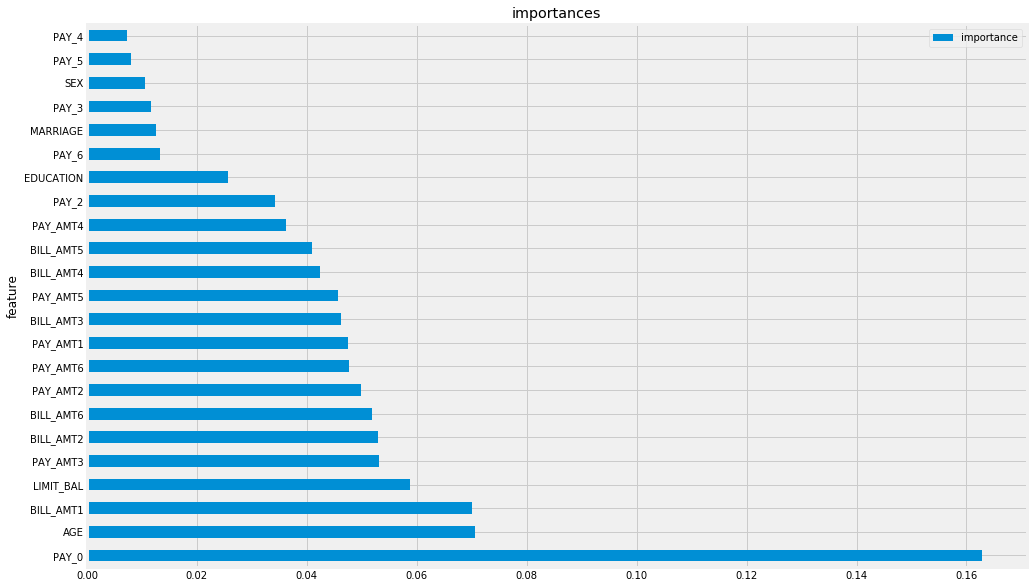

In [48]:
ax = importances.set_index("feature").plot(kind="barh", figsize=(15, 10))
ax.set_title("importances")


上表显示，拟合中最重要的特征是PAY_0，和上一章统计模型的结果相匹配。更值得注意的是第2、第3和第5个特征，这3个特征在进行统计测试前没有显示出重要性。这意味着，这种特征选择方法有可能带来一些新的结果。

回想一下，之前我们使用scikit-learn内置的包装器SelectKBest，基于排序函数(例如ANOVA的p值)取前k个特征。下面会引入一个新的包装器SelectFromModel，和SelectKBest一样选取最重要的前k个特征。但是，它会使用机器学习模型的内部指标来评估特征的重要性，不使用统计测试的p值。我们用下面的代码定义SelectFromModel:

In [49]:
# 和 SelectKBest 相似，但不是统计测试
from sklearn.feature_selection import SelectFromModel

SelectFromModel和SelectKBest相比最大的不同之处在于不使用k(需要保留的特征数):SelectFromModel使用阈值，代表重要性的最低限度。通过这种方式，这种基于模型的选择器可以脱离人工筛选的过程，只保留与流水线所需同等数量的特征。我们实例化这个类:

In [50]:
# 实例化一个类，按照决策树分类器的内部指标排序重要性，选择特征
select_from_model = SelectFromModel(DecisionTreeClassifier(), threshold=.05)

In [51]:
selectd_X = select_from_model.fit_transform(X, y)
selectd_X.shape
# numpy type

(30000, 8)

了解了模块的基本原理后，我们可以在流水线中应用选择功能。我们需要击败的准确率是0.8206，之前的相关性选择器和ANOVA都得到了这个准确率(因为选择的特征相同):

In [52]:
tree_pipe_params

{'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

In [53]:
# 为后面加速
tree_pipe_params = {"classifier__max_depth": [1, 3, 5, 7]}

from sklearn.pipeline import Pipeline

select = SelectFromModel(DecisionTreeClassifier())

select_from_pipe = Pipeline([
    ("select", select),
    ("classifier", d_tree)
])
select_from_pipe_params = deepcopy(tree_pipe_params)
select_from_pipe_params.update({
    "select__threshold": [.01, .05, .1, .2, .25, .3, .4, .5, .6, "mean", "median", "2.*mean"],
    'select__estimator__max_depth': [None, 1, 3, 5, 7],
})

print(select_from_pipe_params)

{'classifier__max_depth': [1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 'mean', 'median', '2.*mean'], 'select__estimator__max_depth': [None, 1, 3, 5, 7]}


In [54]:
get_best_model_and_accuracy(select_from_pipe, select_from_pipe_params, 
                           X, y)
# 没有比原来的更好

Best Accuracy: 0.8202666666666667
Best Parameters: {'classifier__max_depth': 3, 'select__estimator__max_depth': None, 'select__threshold': 0.01}
Average Time to Fit (s):0.146
Average Time to Score (s):0.002


首先注意，我们可以用一些保留字作为阈值参数的一部分，并不是必须选择表示最低重要性的浮点数。例如，mean的阈值只选择比均值更重要的特征，median的阈值只选择比中位数更重要的特征。我们还可以用这些保留字的倍数，例如2.*mean代表比均值重要两倍的特征。

现在查看基于决策树的选择器选出了哪些特征，可以使用SelectFromModel的get_support()方法。这个方法会返回一个数组，其中的每个布尔值代表一个特征，从而告诉我们保留了哪些特征，如下所示:

In [55]:
# 设置流水线最佳参数
select_from_pipe.set_params(
    **{'classifier__max_depth': 3, 'select__estimator__max_depth': None, 'select__threshold': 0.01})
# 拟合数据
select_from_pipe.steps[0][1].fit(X, y)
# 列出选择的列
X.columns[select_from_pipe.steps[0][1].get_support()]

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

这棵树选择了除了两个特征外的所有其他特征，但是和什么都不选的树性能没什么区别。

#### 3. 线性模型和正则化

SelectFromModel可以处理任何包括feature_importances_或coef_属性的机器学习模型。基于树的模型会暴露前者，线性模型则会暴露后者。在拟合后，线性回归、逻辑回归、支持向量机(SVM，supportvectormachine)等线性模型会将一个系数放在特征的斜率(重要性)前面。SelectFromModel会认为这个系数等同于重要性，并根据拟合时的系数选择特征。

然而，在使用模型之前，我们需要引入正则化的概念，以选择真正有用的特征。

- 正则化简介

在线性模型中，正则化是一种对模型施加额外约束的方法，目的是防止过拟合，并改进数据泛化能力。正则化通过对需要优化的损失函数添加额外的条件来完成，意味着在拟合时，正则化的线性模型有可能严重减少甚至损坏特征。

- 另一个特征重要性指标:线性模型参数

和之前用树的方法一样，我们可以用 L1 和 L2 正则化为特征选择寻找最佳系数。我们用逻辑回归模型作为选择器，在 L1 和 L2 范数上进行网格搜索:

In [56]:
# 用正则化后的逻辑回归进行选择
logistic_selector = SelectFromModel(LogisticRegression())

# 新流水线，用 LogistisRegression 的参数进行排列
regularization_pipe = Pipeline([
    ("select", logistic_selector),
    ("classifier", tree)
])
regularization_pipe_params = deepcopy(tree_pipe_params)

# L1和L2正则化
regularization_pipe_params.update({
    "select__threshold": [.01, .05, .1, "mean", "median", "2.*mean"],
    "select__estimator__penalty": ['l1', 'l2'],
})

print(regularization_pipe_params)

{'classifier__max_depth': [1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__penalty': ['l1', 'l2']}


In [57]:
get_best_model_and_accuracy(regularization_pipe, regularization_pipe_params, X, y)
# 比原来的好，实际上是目前最好的，也快得多

Best Accuracy: 0.8211666666666667
Best Parameters: {'classifier__max_depth': 5, 'select__estimator__penalty': 'l1', 'select__threshold': 0.01}
Average Time to Fit (s):0.496
Average Time to Score (s):0.002


现在的准确率终于超过统计测试选择器了。再次使用SelectFromModel的get_support()方法，列出选择的特征:

In [58]:
# 设置流水线最佳参数
regularization_pipe.set_params(
**{'classifier__max_depth': 5, 'select__estimator__penalty': 'l1', 'select__threshold': 0.01})

# 拟合数据
regularization_pipe.steps[0][1].fit(X, y)

# 列出选择的列
X.columns[regularization_pipe.steps[0][1].get_support()]

Index(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5'],
      dtype='object')

非常好!基于逻辑回归的选择器选择了大部分的PAY_X特征，也发现了性别、教育和婚姻状况可以帮助预测。接下来用SelectFromModel模块在支持向量机分类器上进行测试。

支持向量机是分类模型，在空间中绘制线性边界，对二分数据进行分类。这些线性边界叫作支持向量。目前看来，逻辑回归分类器和支持向量分类器(SVC)的最大区别在于，后者会最大优化二分类项目的准确性，而前者对属性的建模更好。像之前决策树和逻辑回归一样，我们用scikit-learn实现一个线性SVC模型，代码如下:

In [59]:
# SVC 是线性模型，用线性支持在欧几里得空间内分割数据 
# 只能分割二分数据
from sklearn.svm import LinearSVC

# 用SVC取参数
svc_selector = SelectFromModel(LinearSVC())
svc_pipe = Pipeline([
    ("select", svc_selector),
    ("classifier", tree)
])

svc_pipe_params = deepcopy(tree_pipe_params)

svc_pipe_params.update({
    'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
    'select__estimator__penalty': ['l1', 'l2'],
    'select__estimator__loss': ['squared_hinge', 'hinge'],
    'select__estimator__dual': [True, False]
})

print(svc_pipe_params)

{'classifier__max_depth': [1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__penalty': ['l1', 'l2'], 'select__estimator__loss': ['squared_hinge', 'hinge'], 'select__estimator__dual': [True, False]}


In [60]:
get_best_model_and_accuracy(svc_pipe, svc_pipe_params, 
                            X, y)
# 刷新了纪录

Best Accuracy: 0.8212333333333334
Best Parameters: {'classifier__max_depth': 5, 'select__estimator__dual': False, 'select__estimator__loss': 'squared_hinge', 'select__estimator__penalty': 'l1', 'select__threshold': 0.01}
Average Time to Fit (s):0.812
Average Time to Score (s):0.001


In [61]:
# 设置流水线最佳参数
svc_pipe.set_params(
    **{'classifier__max_depth': 5, 
       'select__estimator__dual': False, 
       'select__estimator__loss': 'squared_hinge', 
       'select__estimator__penalty': 'l1', 
       'select__threshold': 0.01})
# 拟合数据
svc_pipe.steps[0][1].fit(X, y)
# 列出选择的列
X.columns[svc_pipe.steps[0][1].get_support()]

Index(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_5'], dtype='object')

与逻辑回归比，唯一的区别是 PAY_4 特征。但是可以看到，移除单个特征不会影响流水线的性能。

## 5.4 选用正确的特征选择方法

现在你有可能感到本章的信息过多，难以消化。我们演示了几种选择特征的方法，其中一部分基于统计学，另一部分基于机器学习模型的二次输出。一个很自然的问题是:应该如何选用特征选择方法?理论上说，最理想的状况是，你可以像本章这样多次尝试，但我们知道这样是不可行的。下面是一些经验，可以在判断特征选择方法的优劣时参考。

- 如果特征是分类的，那么从SelectKBest开始，用卡方或基于树的选择器。
- 如果特征基本是定量的(例如本例)，用线性模型和基于相关性的选择器一般效果更好。
- 如果是二元分类问题，考虑使用SelectFromModel和SVC，因为SVC会查找优化二元分类任务的系数。
- 在手动选择前，探索性数据分析会很有益处。不能低估领域知识的重要性。

这些只是指导性建议。作为数据科学家，你最终要确定保留哪些特征以优化指标。本书提供的方法可以帮助你在噪声和多重共线性中挖掘潜在的特征。